Initial dataset shape: (1005167, 5)
Initial dataset preview:
   product_number         department_desc  discount date_of_order  orders
0               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-01       0
1               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-02       0
2               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-03       5
3               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-04       0
4               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-05       0
Dataset shape after removing duplicates: (1005167, 5)

Rows with Missing Dates (retained for now):
Empty DataFrame
Columns: [product_number, department_desc, discount, date_of_order, orders]
Index: []
Dataset shape after handling missing dates: (1005167, 5)

Handling Missing Values...
Remaining missing values after imputation:
product_number     0
department_desc    0
discount           0
date_of_order      0
orders             0
dtype: int64

Handling rows with the same date and different 

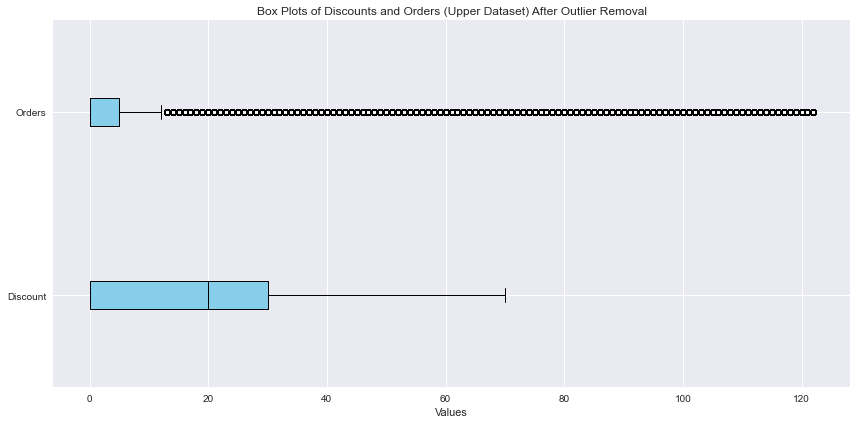

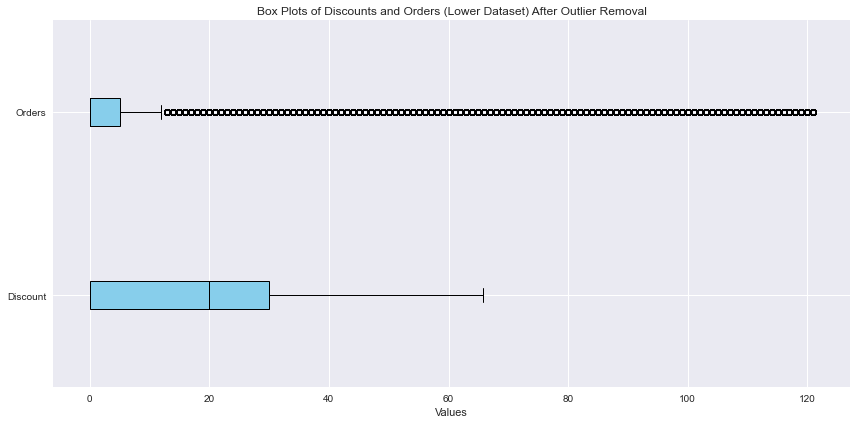

Data preprocessing completed successfully!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '2022_orders_discount_data.csv'  # Replace with your file path
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")
print(f"Initial dataset preview:\n{data_cleaned.head()}")

# 1. Remove duplicates
data_cleaned.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Handle Missing Dates
# Convert `date_of_order` to datetime and set format explicitly to 'YYYY-MM-DD'
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')

# Identify and print rows with missing dates
missing_date_rows = data_cleaned[data_cleaned['date_of_order'].isnull()]
print("\nRows with Missing Dates (retained for now):")
print(missing_date_rows)

# Replace missing dates with the earliest available date
data_cleaned['date_of_order'] = data_cleaned['date_of_order'].fillna(data_cleaned['date_of_order'].min())
print(f"Dataset shape after handling missing dates: {data_cleaned.shape}")

# 3. Handle Missing Values
print("\nHandling Missing Values...")

# Impute missing values for 'department_desc' with 'Unknown'
data_cleaned['department_desc'] = data_cleaned['department_desc'].fillna('Unknown')

# Impute missing values for 'discount' and 'orders' with their respective median
data_cleaned['discount'] = data_cleaned['discount'].fillna(data_cleaned['discount'].median())
data_cleaned['orders'] = data_cleaned['orders'].fillna(data_cleaned['orders'].median())

# Verify remaining missing values
print(f"Remaining missing values after imputation:\n{data_cleaned.isnull().sum()}")

# 4. Handle Rows with Same Date and Different Discounts
print("\nHandling rows with the same date and different discounts...")
grouped_data = data_cleaned.groupby(['product_number', 'date_of_order'])

# Extract rows with the highest and lowest discounts for each product and date
upper_value_data = grouped_data.apply(lambda x: x.loc[x['discount'].idxmax()]).reset_index(drop=True)
lower_value_data = grouped_data.apply(lambda x: x.loc[x['discount'].idxmin()]).reset_index(drop=True)

print(f"Upper Value Dataset Shape: {upper_value_data.shape}")
print(f"Lower Value Dataset Shape: {lower_value_data.shape}")

# 5. Custom Outlier Removal using Percentiles
def remove_outliers_custom(df, column, lower_percentile, upper_percentile):
    """
    Removes outliers based on percentile thresholds.
    Arguments:
    df : pandas.DataFrame - Input dataframe.
    column : str - Column name for which outliers need to be removed.
    lower_percentile : int - Lower percentile for threshold (default=1).
    upper_percentile : int - Upper percentile for threshold (default=99).
    Returns:
    pandas.DataFrame - DataFrame with outliers removed.
    """
    lower_bound = np.percentile(df[column], lower_percentile)
    upper_bound = np.percentile(df[column], upper_percentile)
    print(f"Outlier removal thresholds for {column}: Lower = {lower_bound}, Upper = {upper_bound}")
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Before outlier removal
print("\nUpper Value Data Before Outlier Removal:")
print(upper_value_data[['discount', 'orders']].describe())

print("\nLower Value Data Before Outlier Removal:")
print(lower_value_data[['discount', 'orders']].describe())

# Remove outliers
print("\nRemoving outliers from both datasets...")
original_shape_upper = upper_value_data.shape
original_shape_lower = lower_value_data.shape
upper_value_data = remove_outliers_custom(upper_value_data, 'discount', lower_percentile=1, upper_percentile=99)
upper_value_data = remove_outliers_custom(upper_value_data, 'orders', lower_percentile=1, upper_percentile=99)
lower_value_data = remove_outliers_custom(lower_value_data, 'discount', lower_percentile=1, upper_percentile=99)
lower_value_data = remove_outliers_custom(lower_value_data, 'orders', lower_percentile=1, upper_percentile=99)

print(f"Upper dataset shape before: {original_shape_upper}, after: {upper_value_data.shape}")
print(f"Lower dataset shape before: {original_shape_lower}, after: {lower_value_data.shape}")

# After outlier removal
print("\nUpper Value Data After Outlier Removal:")
print(upper_value_data[['discount', 'orders']].describe())

print("\nLower Value Data After Outlier Removal:")
print(lower_value_data[['discount', 'orders']].describe())

# Visualize the data after outlier removal
fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot([upper_value_data['discount'], upper_value_data['orders']], labels=['Discount', 'Orders'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'), medianprops=dict(color='black'))
ax.set_title('Box Plots of Discounts and Orders (Upper Dataset) After Outlier Removal')
ax.set_xlabel('Values')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot([lower_value_data['discount'], lower_value_data['orders']], labels=['Discount', 'Orders'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'), medianprops=dict(color='black'))
ax.set_title('Box Plots of Discounts and Orders (Lower Dataset) After Outlier Removal')
ax.set_xlabel('Values')

plt.tight_layout()
plt.show()

print("Data preprocessing completed successfully!")

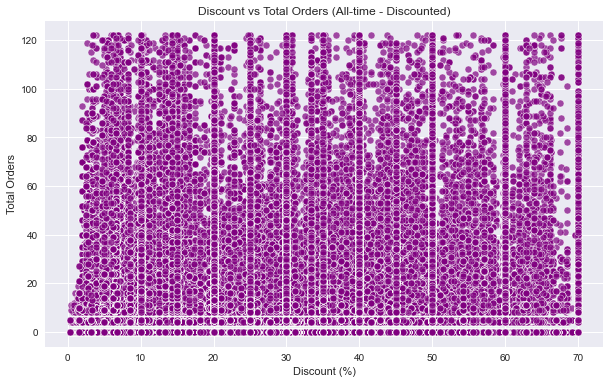

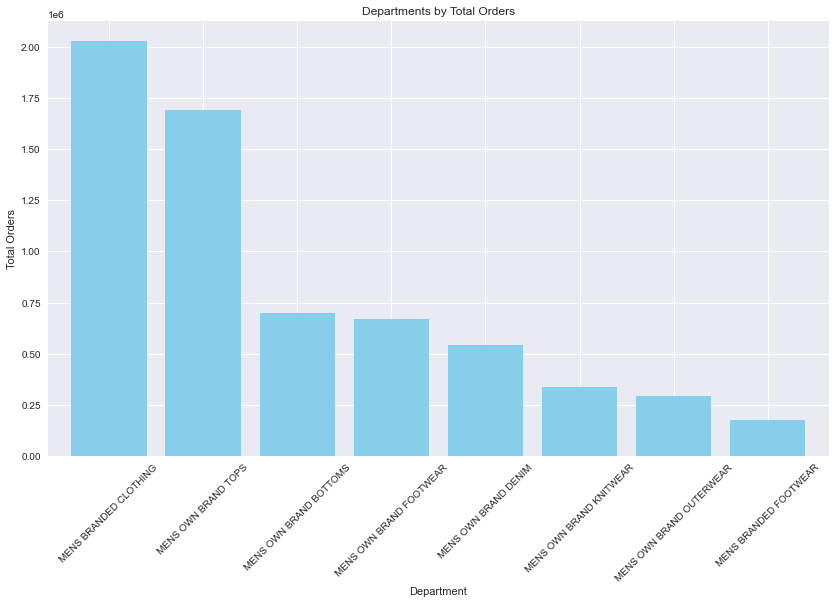

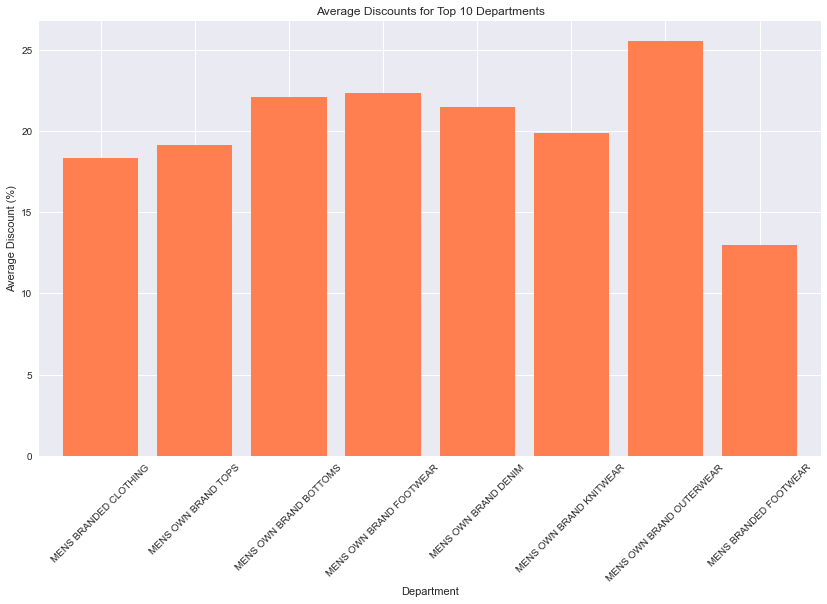

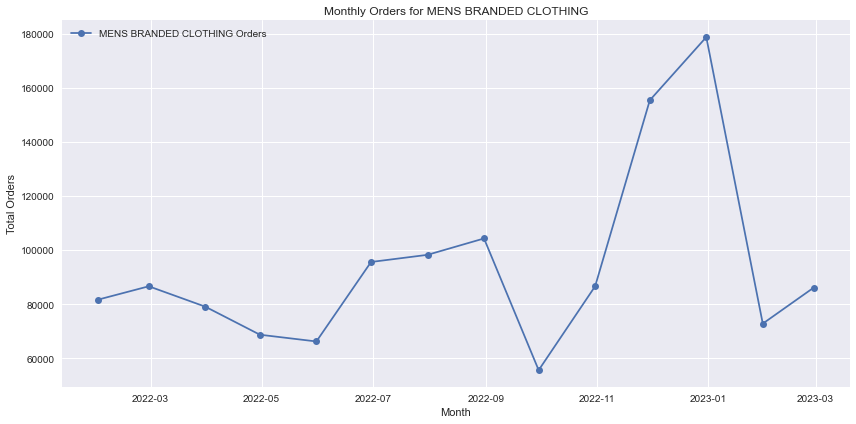

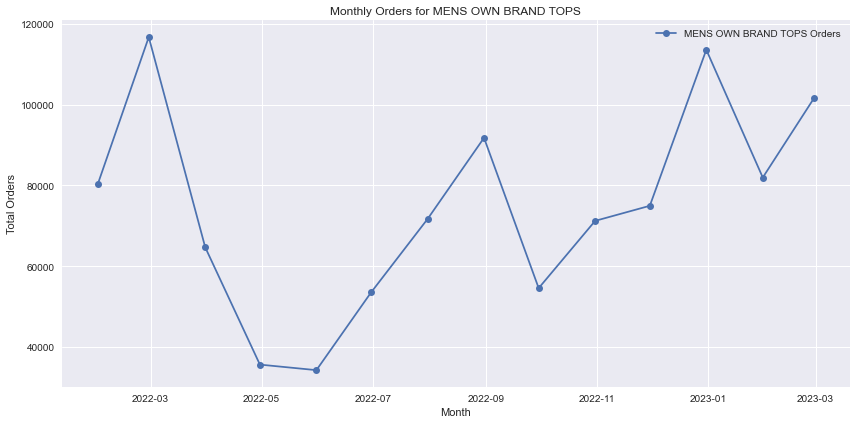

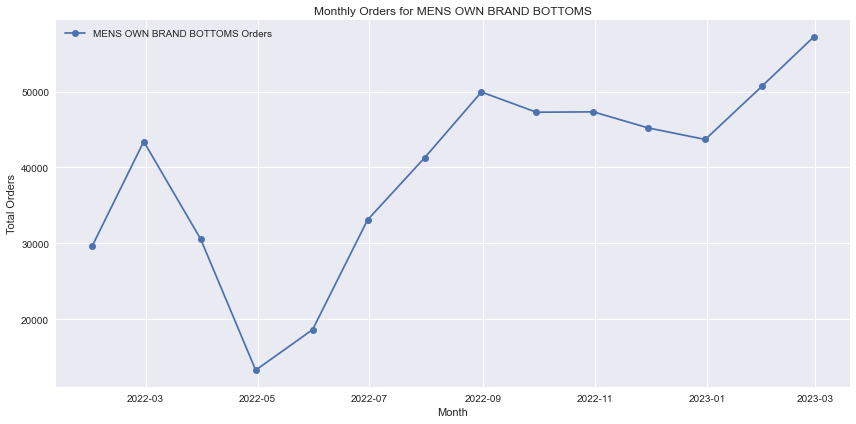

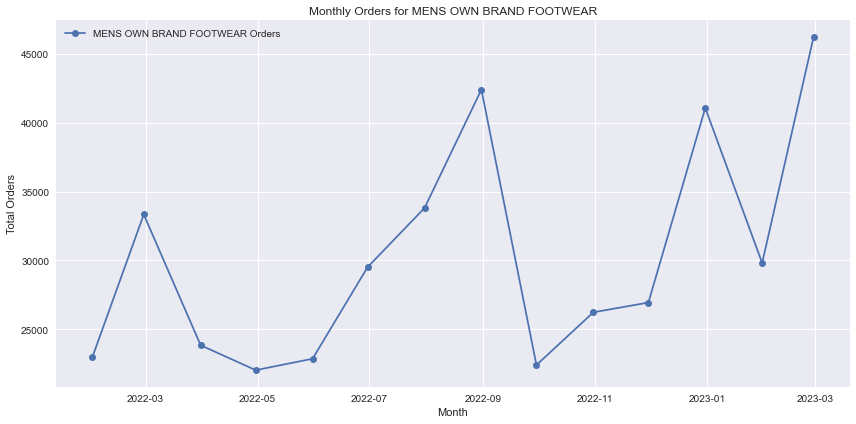

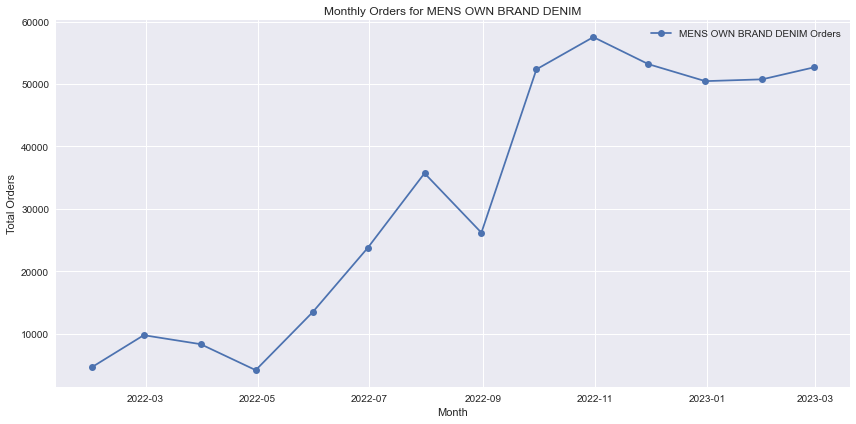

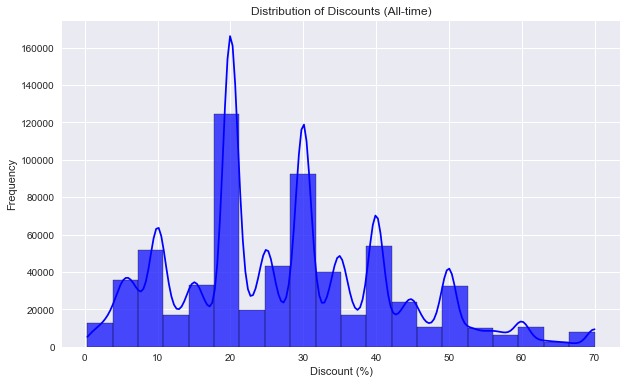

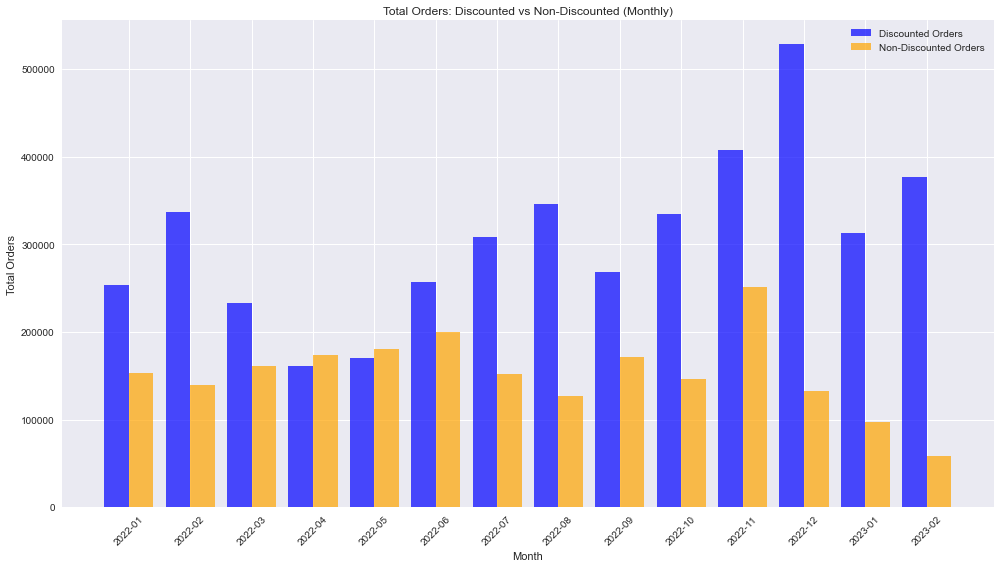

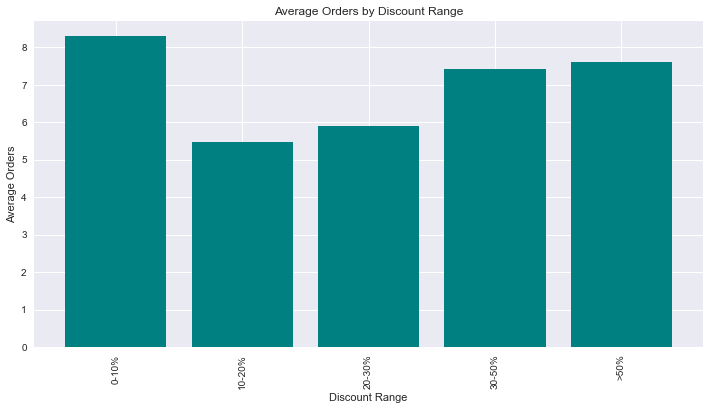

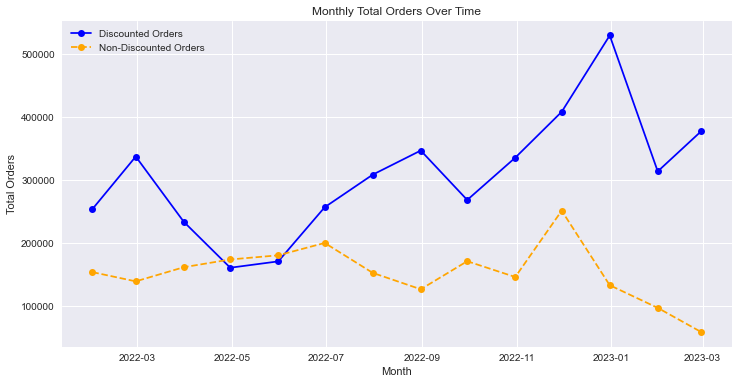

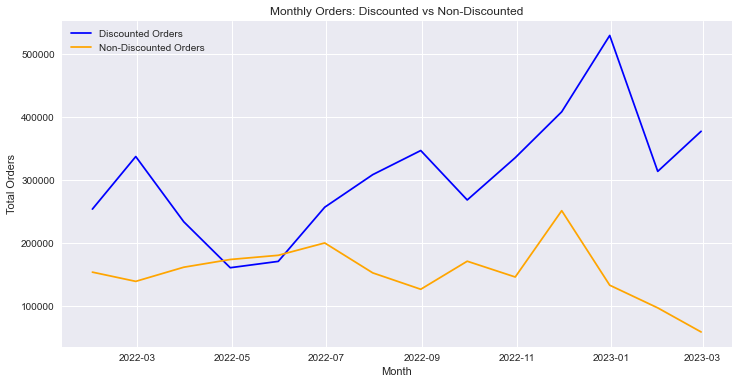

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load cleaned data
file_path = 'cleaned_orders_discount_data_upper.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the date column is datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Validate discount segregation
if not all(data_cleaned['discount'] >= 0):
    raise ValueError("Discount column contains negative values, which are invalid.")

# Separate discounted and non-discounted data
discounted_data = data_cleaned[data_cleaned['discount'] > 0]
non_discounted_data = data_cleaned[data_cleaned['discount'] == 0]

# Aggregate data monthly for discounted and non-discounted separately
discounted_monthly = discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()

non_discounted_monthly = non_discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum'
}).reset_index()

# Merge the two datasets for analysis
monthly_data = pd.merge(
    discounted_monthly,
    non_discounted_monthly,
    on='date_of_order',
    how='outer',
    suffixes=('_discounted', '_non_discounted')
)

# Replace NaN with 0 to handle months without any orders for a specific category
monthly_data.fillna(0, inplace=True)

# Add discount range for analysis (for discounted data only)
bins = [0, 10, 20, 30, 50, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-50%', '>50%']
if 'discount_discounted' in monthly_data.columns:
    monthly_data['discount_range'] = pd.cut(monthly_data['discount_discounted'], bins=bins, labels=labels)

### 1. Discount vs Orders Scatter Plot (All-time Aggregation)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='orders', data=discounted_data, alpha=0.7, color="purple")
plt.title('Discount vs Total Orders (All-time - Discounted)')
plt.xlabel('Discount (%)')
plt.ylabel('Total Orders')
plt.grid(True)
plt.show()

### 2. Top Departments by Total Orders (Granular Analysis)
dept_aggregated = data_cleaned.groupby('department_desc').agg({
    'orders': 'sum',
    'discount': 'mean'
}).sort_values(by='orders', ascending=False)

# Top 10 Departments by Total Orders
plt.figure(figsize=(14, 8))
dept_aggregated['orders'].head(10).plot(kind='bar', color='skyblue', width=0.8)
plt.title('Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Average Discounts for Top 10 Departments
plt.figure(figsize=(14, 8))
dept_aggregated['discount'].head(10).plot(kind='bar', color='coral', width=0.8)
plt.title('Average Discounts for Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Average Discount (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 3. Monthly Department-Level Analysis
top_departments = dept_aggregated.head(5).index

# For each department, plot monthly discounted orders
for department in top_departments:
    dept_data = discounted_data[discounted_data['department_desc'] == department]
    dept_monthly = dept_data.resample('M', on='date_of_order').agg({
        'orders': 'sum',
        'discount': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(dept_monthly['date_of_order'], dept_monthly['orders'], marker='o', label=f'{department} Orders')
    plt.title(f'Monthly Orders for {department}')
    plt.xlabel('Month')
    plt.ylabel('Total Orders')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 4. Distribution of Discounts (Granular)
plt.figure(figsize=(10, 6))
sns.histplot(discounted_data['discount'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Discounts (All-time)')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 5. Discounted vs Non-Discounted Sales (Monthly)
plt.figure(figsize=(14, 8))
x_positions = np.arange(len(monthly_data['date_of_order']))
plt.bar(
    x_positions - 0.2,
    monthly_data['orders_discounted'],
    width=0.4,
    label='Discounted Orders',
    color='blue',
    alpha=0.7
)
plt.bar(
    x_positions + 0.2,
    monthly_data['orders_non_discounted'],
    width=0.4,
    label='Non-Discounted Orders',
    color='orange',
    alpha=0.7
)
plt.xticks(x_positions, monthly_data['date_of_order'].dt.strftime('%Y-%m'), rotation=45)
plt.title('Total Orders: Discounted vs Non-Discounted (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Average Orders by Discount Range
avg_orders_by_discount = discounted_data.groupby(pd.cut(discounted_data['discount'], bins=bins, labels=labels))['orders'].mean()

plt.figure(figsize=(12, 6))
avg_orders_by_discount.plot(kind='bar', color='teal', width=0.8)
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

### 7. Monthly Total Orders Over Time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['date_of_order'], monthly_data['orders_discounted'], marker='o', color='blue', label='Discounted Orders')
plt.plot(monthly_data['date_of_order'], monthly_data['orders_non_discounted'], marker='o', linestyle='--', color='orange', label='Non-Discounted Orders')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()

### 8. Monthly Orders: Discounted vs Non-Discounted (Granular Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_of_order', y='orders_discounted', data=monthly_data, label='Discounted Orders', color='blue')
sns.lineplot(x='date_of_order', y='orders_non_discounted', data=monthly_data, label='Non-Discounted Orders', color='orange')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()



In [6]:
import pandas as pd
import numpy as np
from scipy import stats

# Load the dataset
file_path = 'cleaned_orders_discount_data_upper.csv'  # Replace with your file path
data = pd.read_csv(file_path)
data['date_of_order'] = pd.to_datetime(data['date_of_order'])
print("Dataset loaded successfully.")

# Step 1: Descriptive Statistics
print("\nDescriptive Statistics:")
print(data[['orders', 'discount']].describe())

# Additional summaries
print("\nSummary Statistics for Orders by Department:")
print(data.groupby('department_desc')['orders'].describe())

# Add columns for additional analysis
data['is_weekend'] = data['date_of_order'].dt.dayofweek >= 5
median_orders = data['orders'].median()
median_discount = data['discount'].median()

# Step 2: T-Test - Weekday vs Weekend Orders
weekday_orders = data[~data['is_weekend']]['orders']
weekend_orders = data[data['is_weekend']]['orders']
t_stat, p_value = stats.ttest_ind(weekday_orders, weekend_orders)

print("\nT-Test: Weekday vs Weekend Orders")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. Significant difference between weekday and weekend orders.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant difference between weekday and weekend orders.")

# Step 3: Chi-Square Test - Association Between High Orders and High Discounts
contingency_table = pd.crosstab(data['orders'] > median_orders, data['discount'] > median_discount)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("\nChi-Square Test: High Orders vs High Discounts")
print(f"Chi-square Statistic: {chi2:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. Association exists between high orders and high discounts.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No association between high orders and high discounts.")

# Step 4: ANOVA - Orders Across Departments
departments = data['department_desc'].unique()
department_orders = [data[data['department_desc'] == dept]['orders'] for dept in departments]
f_stat, p_value = stats.f_oneway(*department_orders)

print("\nOne-Way ANOVA: Orders Across Departments")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. Significant difference in mean orders across departments.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant difference in mean orders across departments.")

# Step 5: Shapiro-Wilk Test - Normality of Orders
stat, p_value = stats.shapiro(data['orders'])

print("\nShapiro-Wilk Test: Normality of Orders")
print(f"Statistic: {stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. Orders are not normally distributed.")
else:
    print("Conclusion: Fail to reject the null hypothesis. Orders are normally distributed.")

# Step 6: Correlation Coefficients - Orders vs Discount
# Pearson Correlation (Linear Relationship)
pearson_corr, pearson_p_value = stats.pearsonr(data['orders'], data['discount'])
print("\nPearson Correlation: Orders vs Discount")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}, P-value: {pearson_p_value:.4f}")
if pearson_p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. Significant linear correlation between orders and discount.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant linear correlation between orders and discount.")

# Spearman Correlation (Monotonic Relationship)
spearman_corr, spearman_p_value = stats.spearmanr(data['orders'], data['discount'])
print("\nSpearman Correlation: Orders vs Discount")
print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}, P-value: {spearman_p_value:.4f}")
if spearman_p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. Significant monotonic correlation between orders and discount.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant monotonic correlation between orders and discount.")

# Step 7: Mann-Whitney U Test - Orders Before and After Median Date
median_date = data['date_of_order'].median()
before_median = data[data['date_of_order'] < median_date]['orders']
after_median = data[data['date_of_order'] >= median_date]['orders']
stat, p_value = stats.mannwhitneyu(before_median, after_median)

print("\nMann-Whitney U Test: Orders Before vs After Median Date")
print(f"Statistic: {stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. Orders differ significantly before and after the median date.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant difference in orders before and after the median date.")



Dataset loaded successfully.

Descriptive Statistics:
              orders       discount
count  930620.000000  930620.000000
mean        6.918035      19.156447
std        15.016575      17.712540
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000      20.000000
75%         5.000000      30.000000
max       122.000000      70.000000

Summary Statistics for Orders by Department:
                             count       mean        std  min  25%  50%   75%  \
department_desc                                                                 
MENS BRANDED CLOTHING     434664.0   4.667191  11.223070  0.0  0.0  0.0   5.0   
MENS BRANDED FOOTWEAR      84044.0   2.079875   5.363882  0.0  0.0  0.0   0.0   
MENS OWN BRAND BOTTOMS     66548.0  10.515072  18.093368  0.0  0.0  4.0  13.0   
MENS OWN BRAND DENIM       37923.0  14.294992  24.923018  0.0  0.0  4.0  16.0   
MENS OWN BRAND FOOTWEAR    90732.0   7.381729  14.025881  0.0  0.0  0.0   9.0   
MENS OWN 

/Users/atiyamahboob/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 930620.
  res = hypotest_fun_out(*samples, **kwds)


Dataset loaded successfully.
Data filtered for department: MENS OWN BRAND BOTTOMS
Number of records: 66548

t-test for department: MENS OWN BRAND BOTTOMS
H0: In the MENS OWN BRAND BOTTOMS department, the mean number of orders for products with low discounts is less than or equal to the mean for products with high discounts.
H1: In the MENS OWN BRAND BOTTOMS department, the mean number of orders for products with low discounts is greater than the mean for products with high discounts.
t-statistic: 25.6775
p-value: 0.0000
Conclusion: Reject H0
Detailed conclusion: There is statistically significant evidence that in the MENS OWN BRAND BOTTOMS department, the mean number of orders for products with lower discounts is greater than for products with higher discounts.


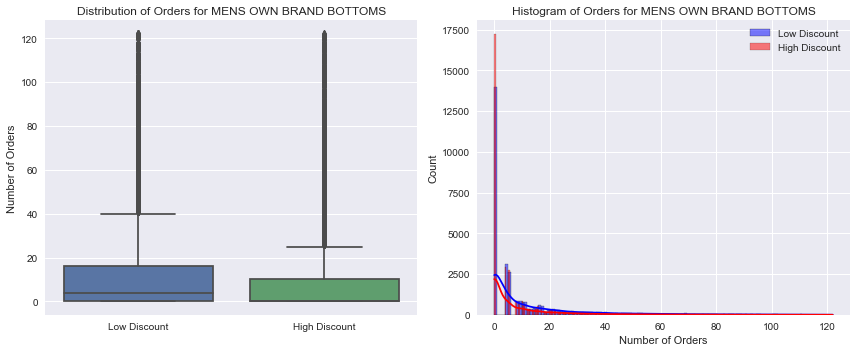

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'cleaned_orders_discount_data_upper.csv'  # Replace with your file path
data = pd.read_csv(file_path)
data['date_of_order'] = pd.to_datetime(data['date_of_order'])
print("Dataset loaded successfully.")

# Filter the dataset for the specific department
chosen_department = "MENS OWN BRAND BOTTOMS"
dept_data = data[data['department_desc'] == chosen_department]
print(f"Data filtered for department: {chosen_department}")
print(f"Number of records: {len(dept_data)}")

# Calculate median discount to split into low and high discount groups
median_discount = dept_data['discount'].median()
low_discount_orders = dept_data[dept_data['discount'] < median_discount]['orders']
high_discount_orders = dept_data[dept_data['discount'] >= median_discount]['orders']

# Perform t-test
t_stat, p_value = stats.ttest_ind(low_discount_orders, high_discount_orders, alternative='greater')

print(f"\nt-test for department: {chosen_department}")
print(f"H0: In the {chosen_department} department, the mean number of orders for products with low discounts is less than or equal to the mean for products with high discounts.")
print(f"H1: In the {chosen_department} department, the mean number of orders for products with low discounts is greater than the mean for products with high discounts.")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    conclusion = "Reject H0"
    detailed_conclusion = (f"There is statistically significant evidence that in the {chosen_department} department, "
                           "the mean number of orders for products with lower discounts is greater "
                           "than for products with higher discounts.")
else:
    conclusion = "Fail to reject H0"
    detailed_conclusion = (f"There is not enough evidence to conclude that in the {chosen_department} department, "
                           "the mean number of orders for products with lower discounts is greater "
                           "than for products with higher discounts.")

print("Conclusion:", conclusion)
print("Detailed conclusion:", detailed_conclusion)

# Visualizations
plt.figure(figsize=(12, 5))

# Box plot for low and high discount groups
plt.subplot(1, 2, 1)
sns.boxplot(x=['Low Discount']*len(low_discount_orders) + ['High Discount']*len(high_discount_orders),
            y=list(low_discount_orders) + list(high_discount_orders))
plt.title(f'Distribution of Orders for {chosen_department}')
plt.ylabel('Number of Orders')

# Histogram for low and high discount groups
plt.subplot(1, 2, 2)
sns.histplot(low_discount_orders, kde=True, color='blue', alpha=0.5, label='Low Discount')
sns.histplot(high_discount_orders, kde=True, color='red', alpha=0.5, label='High Discount')
plt.title(f'Histogram of Orders for {chosen_department}')
plt.xlabel('Number of Orders')
plt.legend()

plt.tight_layout()
plt.show()

Dataset loaded successfully.
Date column converted to datetime.
Data aggregated to monthly level.
Zero discounts replaced with a small value.
Percentage changes calculated.
Elasticity calculated with extreme values handled.
Filtered 6647 elastic records (Elasticity > 1).
Combined elasticity analysis saved to: elasticity_analysis_combined.csv

Top 5 Departments to Focus On:
            department_desc  avg_elasticity  total_orders  avg_discount  \
2    MENS OWN BRAND BOTTOMS       40.480486        129355     26.633735   
3      MENS OWN BRAND DENIM       25.566300        114695     25.527971   
6  MENS OWN BRAND OUTERWEAR       20.329093         51037     31.269213   
7       MENS OWN BRAND TOPS       20.162479        275596     23.480659   
4   MENS OWN BRAND FOOTWEAR       17.679311        100944     28.934672   

   elastic_products_count        type  
2                     240  department  
3                     119  department  
6                     118  department  
7            

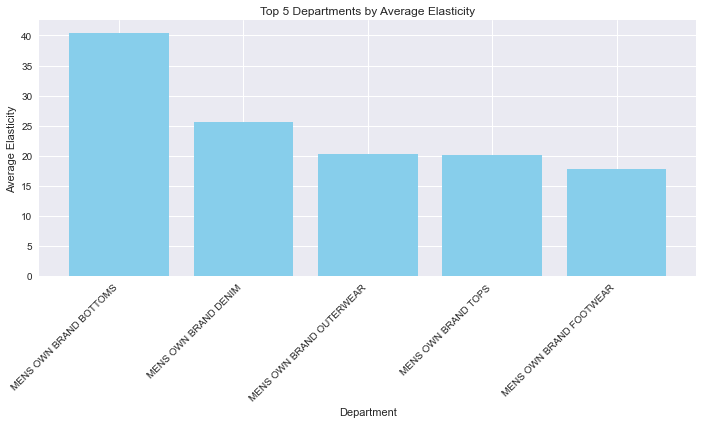

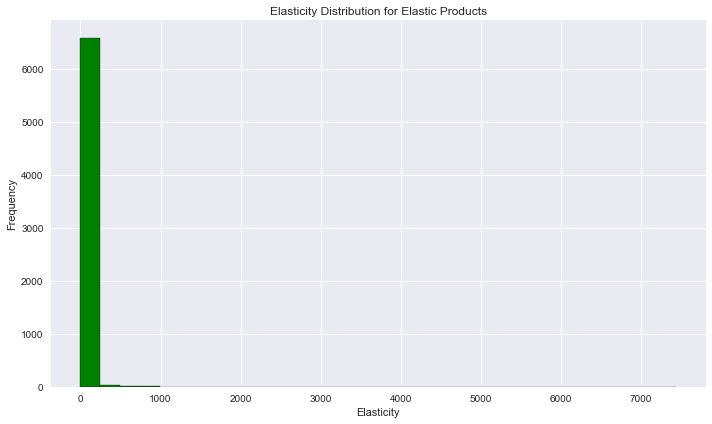

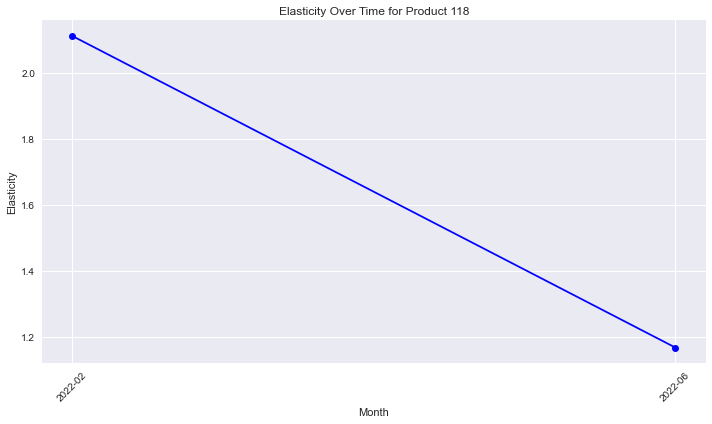

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = 'cleaned_orders_discount_data_upper.csv'  # Replace with your file path
data_cleaned = pd.read_csv(file_path)
print("Dataset loaded successfully.")

# Step 2: Convert date column to datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])
print("Date column converted to datetime.")

# Step 3: Aggregate data at the monthly level
data_cleaned['month'] = data_cleaned['date_of_order'].dt.to_period('M')  # Monthly periods
monthly_data = data_cleaned.groupby(['month', 'department_desc', 'product_number']).agg({
    'orders': 'sum',  # Total orders in the month
    'discount': 'mean'  # Average discount in the month
}).reset_index()
print("Data aggregated to monthly level.")

# Step 4: Handle zero discounts to avoid division errors
monthly_data['discount'] = monthly_data['discount'].replace(0, 1e-6)
print("Zero discounts replaced with a small value.")

# Step 5: Calculate percentage changes for orders and discounts
monthly_data['pct_change_discount'] = monthly_data.groupby('product_number')['discount'].pct_change()
monthly_data['pct_change_orders'] = monthly_data.groupby('product_number')['orders'].pct_change()
print("Percentage changes calculated.")

# Step 6: Calculate elasticity
monthly_data['elasticity'] = np.where(
    (monthly_data['pct_change_discount'] != 0) & (monthly_data['pct_change_orders'].notnull()),
    monthly_data['pct_change_orders'] / monthly_data['pct_change_discount'],
    np.nan  # Set to NaN if elasticity cannot be calculated
)

# Remove `inf`, extreme values, and NaNs
monthly_data = monthly_data[~np.isinf(monthly_data['elasticity'])]  # Remove infinite values
monthly_data = monthly_data[monthly_data['elasticity'] <= 1e6]  # Remove extreme outliers
monthly_data = monthly_data.dropna(subset=['elasticity'])  # Drop NaN values
print("Elasticity calculated with extreme values handled.")

# Step 7: Filter for elastic products (elasticity > 1)
elastic_products = monthly_data[monthly_data['elasticity'] > 1]
print(f"Filtered {len(elastic_products)} elastic records (Elasticity > 1).")

# Step 8: Department-Level Analysis
department_analysis = elastic_products.groupby('department_desc').agg({
    'elasticity': 'mean',  # Average elasticity of elastic products
    'orders': 'sum',  # Total orders for elastic products
    'discount': 'mean',  # Average discount for elastic products
    'product_number': 'nunique'  # Number of unique elastic products
}).reset_index()
department_analysis.rename(columns={
    'elasticity': 'avg_elasticity',
    'orders': 'total_orders',
    'discount': 'avg_discount',
    'product_number': 'elastic_products_count'
}, inplace=True)

# Add "type" column to differentiate department-level data
department_analysis['type'] = 'department'

# Step 9: Product-Level Analysis
product_analysis = elastic_products.groupby(['product_number', 'department_desc']).agg({
    'elasticity': 'mean',  # Average elasticity
    'orders': 'sum',  # Total orders
    'discount': 'mean'  # Average discount
}).reset_index()
product_analysis.rename(columns={
    'elasticity': 'avg_elasticity',
    'orders': 'total_orders',
    'discount': 'avg_discount'
}, inplace=True)

# Add "type" column to differentiate product-level data
product_analysis['type'] = 'product'

# Step 10: Combine Product and Department Analysis
combined_analysis = pd.concat([department_analysis, product_analysis], ignore_index=True)

# Save combined analysis to a single CSV
output_file = 'elasticity_analysis_combined.csv'
combined_analysis.to_csv(output_file, index=False)
print(f"Combined elasticity analysis saved to: {output_file}")

# Step 11: Summary of Recommendations
print("\nTop 5 Departments to Focus On:")
print(department_analysis.sort_values(by='avg_elasticity', ascending=False).head(5))

print("\nTop 10 Products to Focus On:")
print(product_analysis.sort_values(by='avg_elasticity', ascending=False).head(10))

# Step 12: Debugging and Validation
print("\nSummary statistics for Elastic Products:")
print(elastic_products['elasticity'].describe())

# Step 13: Visualization for Validation
# Top Departments by Elasticity
top_departments = department_analysis.sort_values(by='avg_elasticity', ascending=False).head(5)
plt.figure(figsize=(10, 6))
plt.bar(top_departments['department_desc'], top_departments['avg_elasticity'], color='skyblue')
plt.title('Top 5 Departments by Average Elasticity')
plt.xlabel('Department')
plt.ylabel('Average Elasticity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Elasticity Distribution
plt.figure(figsize=(10, 6))
plt.hist(elastic_products['elasticity'], bins=30, color='green', edgecolor='black')
plt.title('Elasticity Distribution for Elastic Products')
plt.xlabel('Elasticity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Sample Product Elasticity Over Time
sample_product = elastic_products[elastic_products['product_number'] == elastic_products['product_number'].iloc[0]]
plt.figure(figsize=(10, 6))
plt.plot(sample_product['month'].astype(str), sample_product['elasticity'], marker='o', color='blue')
plt.title(f"Elasticity Over Time for Product {sample_product['product_number'].iloc[0]}")
plt.xlabel('Month')
plt.ylabel('Elasticity')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
plt.style.use('seaborn')

# Load the original data
data = pd.read_csv('cleaned_orders_discount_data_upper.csv')
data['date_of_order'] = pd.to_datetime(data['date_of_order'])

# Filter for selected departments (top 3 most elastic)
selected_departments = ['MENS OWN BRAND BOTTOMS', 'MENS OWN BRAND FOOTWEAR', 'MENS BRANDED CLOTHING']
focused_data = data[data['department_desc'].isin(selected_departments)].copy()

print(f"Total number of products being analyzed: {focused_data['product_number'].nunique()}")
for dept in selected_departments:
    dept_products = focused_data[focused_data['department_desc'] == dept]['product_number'].nunique()
    print(f"{dept}: {dept_products} products")

# Feature Engineering
focused_data['month'] = focused_data['date_of_order'].dt.month
focused_data['day_of_week'] = focused_data['date_of_order'].dt.dayofweek
focused_data['week_of_year'] = focused_data['date_of_order'].dt.isocalendar().week
focused_data['day_of_month'] = focused_data['date_of_order'].dt.day

# Create dummy variables for departments
focused_data = pd.get_dummies(focused_data, columns=['department_desc'])

# Prepare features and target
features = ['discount', 'month', 'day_of_week', 'week_of_year', 'day_of_month'] + \
           [col for col in focused_data.columns if col.startswith('department_desc_')]

# Remove rows with NaN values
focused_data = focused_data.dropna()

X = focused_data[features]
y = focused_data['orders']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Bayesian Ridge': BayesianRidge(n_iter=300, alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=8, random_state=42)
}

# Train and evaluate models
results = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    if name == 'Bayesian Ridge':
        model.fit(X_train_scaled, y_train)
        y_pred, y_std = model.predict(X_test_scaled, return_std=True)
        predictions[name] = {'pred': y_pred, 'std': y_std}
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        predictions[name] = {'pred': y_pred}
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    results[name] = {'R2': r2, 'RMSE': rmse, 'MAE': mae}
    
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

# Model Performance Comparison
plt.figure(figsize=(12, 5))
r2_scores = {name: results[name]['R2'] for name in results.keys()}
rmse_scores = {name: results[name]['RMSE'] for name in results.keys()}

plt.subplot(1, 2, 1)
plt.bar(r2_scores.keys(), r2_scores.values(), color='skyblue')
plt.title('R² Score Comparison')
plt.xticks(rotation=45)
plt.ylabel('R² Score')

plt.subplot(1, 2, 2)
plt.bar(rmse_scores.keys(), rmse_scores.values(), color='salmon')
plt.title('RMSE Comparison')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

# Actual vs Predicted Plot for the Best Model
best_model = max(results.items(), key=lambda x: x[1]['R2'])
print(f"\nBest Model: {best_model[0]}")
print(f"Best R² Score: {best_model[1]['R2']:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions[best_model[0]]['pred'], alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Orders')
plt.ylabel('Predicted Orders')
plt.title(f'Actual vs Predicted Orders ({best_model[0]})')
plt.tight_layout()
plt.show()

# Save results and predictions
results_df = pd.DataFrame(results).T
results_df.to_csv('model_comparison_results.csv')

predictions_df = pd.DataFrame({
    'product_number': focused_data.loc[y_test.index, 'product_number'],
    'actual_orders': y_test,
    'predicted_orders': predictions[best_model[0]]['pred']
})
if best_model[0] == 'Bayesian Ridge':
    predictions_df['prediction_std'] = predictions['Bayesian Ridge']['std']

predictions_df.to_csv('best_model_predictions.csv', index=False)

# Print final summary
print("\nDetailed Results Summary:")
print(results_df)


KeyError: 'date_of_order'